In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy.stats import pearsonr
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from scipy import stats
from scipy.signal import convolve,deconvolve
from sympy import *
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
import warnings
import matplotlib.cbook
import string
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                    'GROWTH_HORMONE_GH':'GH',
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                     'CORTISOL_U_FREE_24h':'Urinary cortisol',
                     'T3_FREE':'T3-free',
                     'T4_FREE':'T4-free',
                     'ESTRADIOL_E_2':'Estradiol',
                     'TESTOSTERONE_TOTAL':'Testosterone',
                     'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ 'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'PROGESTERONE'           :'P4'}

pituitary_unit_dict = {'ACTH':'Percentile',
                       'TSH' :'Percentile',
                       'LH'  :'Percentile',
                       'FSH' :'Percentile',
                       'Prolactin':'Percentile',
                       'GH'  :'Percentile'}

effector_unit_dict  = {'Cortisol':'Percentile',
                       'Urinary cortisol':'Percentile',
                       'T3-free':'Percentile',
                       'T4-free':'Percentile',
                       'Estradiol':'Percentile',
                       'Testosterone': 'Percentile',
                       'IGF1' :'Percentile'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                    'CREATININE_BLOOD':'Creatinine',
                    'Cl':'Cl',
                    'GLUCOSE_BLOOD':'Glucose',
                    'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                    'HGB':'HGB',
                    'MAGNESIUM_BLOOD':'Mg',
                    'POTASSIUM':'K',
                    'SODIUM':'Na',
                    'UREA_BLOOD':'Urea'}
 
month_names = [x[:3] for x in calendar.month_name[1:13]]
letters     = string.ascii_uppercase

In [4]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]

    df = df.loc[df['age_group'] !='[70,80]']
    df = df.loc[df['age_group'] !='[60,70)']
    df = df.loc[df['age_group'] !='[50,60)'] 
    
    df.loc[df['month'] == 12,['month']] = 0
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp*2,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    
    # 2st order cosinor - 4 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp*2,np.pi,maxamp*2,np.pi)])
    
    A21          = res_fit[0]
    phi21        = res_fit[1]
    A22          = res_fit[2]
    phi22        = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,hormone,sex,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)
        
    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        

        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))

        if hormone =='TESTOSTERONE_TOTAL':
            if sex =='male':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars))
                
        elif hormone =='ESTRADIOL_E_2':
            if sex =='female':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars)) 
        else:
            all_tests_acrophase  .append(get_acrophase(pars))
            all_tests_relmaxmin  .append(get_relmaxmin(pars))  

        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
        
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    print(all_tests_acrophase)
    print([aic1,aic2,aic_null])
    best_model = np.argmin(np.array([aic1,aic2,aic_null])) 
    if best_model   == 0:
        print('1st order cosinor')
        return cosinor_tables[0]
    elif best_model == 1:
        print('2nd order cosinor')
        return cosinor_tables[1]
    else:
        print('constant')
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
    
    plt.errorbar(np.arange(0,12),ydat,edat,c='k')
    
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='b')

    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='r')
    plt.xticks(ticks=np.arange(0,12))
    plt.grid()
    plt.show()
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='qunaitle'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat,hormone,sex)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='quantile'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):
            print('--------------')
            print(k,sex)
            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}
            print('acrophase = ' ,acrophase)
            print('maxmin/2 = ' ,maxmin)

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

--------------
CORTISOL_BLOOD female


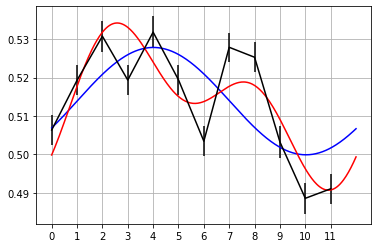

[3.51189728 1.76103523]
[-104.055451991926, -103.852839134027, -101.845710167087]
1st order cosinor
acrophase =  3.511897279649264
maxmin/2 =  0.023385780680418314
--------------
CORTISOL_BLOOD male


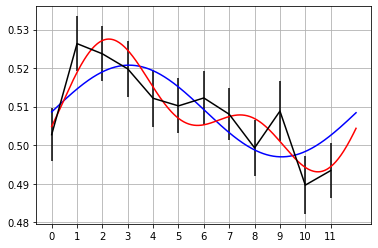

[1.73170102 1.21850397]
[-113.323840576452, -113.258824487961, -108.591168469943]
1st order cosinor
acrophase =  1.7317010182079589
maxmin/2 =  0.021724552415572255
--------------
CORTISOL_BLOOD both


[2.72252601 1.25276074]
[-107.962328628439, -110.372344447912, -104.587855246867]
2nd order cosinor
acrophase =  2.7225260062907375
maxmin/2 =  0.021234271918438092
--------------
CORTISOL_U_FREE_24h female


[1.94206639 0.36360631]
[-106.505010708729, -96.8946188674612, -94.1606880710866]
1st order cosinor
acrophase =  1.9420663869453434
maxmin/2 =  0.03894252424424849
--------------
CORTISOL_U_FREE_24h male


[11.83698393  3.05245037]
[-88.1420144663385, -79.7894325736794, -93.3227251791421]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
CORTISOL_U_FREE_24h both


[1.60833583 0.84068861]
[-112.171671983335, -102.523557513340, -100.462898369792]
1st order cosinor
acrophase =  1.6083358332260302
maxmin/2 =  0.029677485536163256
--------------
T3_FREE female


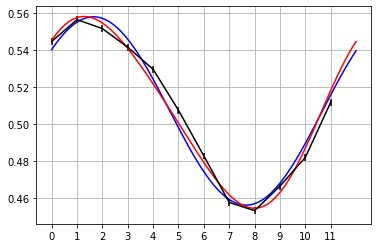

[1.02876132 0.16897539]
[-118.787100418136, -115.325253345619, -79.6571268603822]
1st order cosinor
acrophase =  1.028761322681227
maxmin/2 =  0.05165840118047436
--------------
T3_FREE male


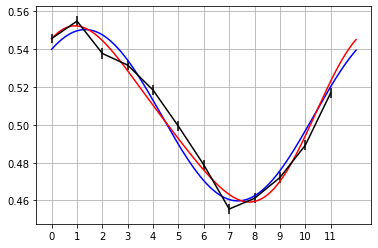

[0.99617824 0.06241705]
[-115.880207382162, -112.296971736566, -82.2490747794834]
1st order cosinor
acrophase =  0.9961782383883282
maxmin/2 =  0.049890913175826515
--------------
T3_FREE both


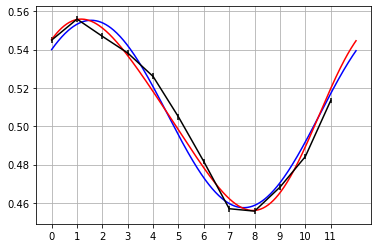

[ 1. -0.]
[-118.035876763199, -114.884467690259, -80.5546227570945]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.050201078508830106
--------------
T4_FREE female


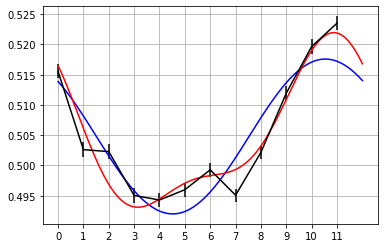

[10.99043797  0.09843137]
[-127.420795895970, -130.577888442528, -110.901858212076]
2nd order cosinor
acrophase =  10.990437972516704
maxmin/2 =  0.014866278590138773
--------------
T4_FREE male


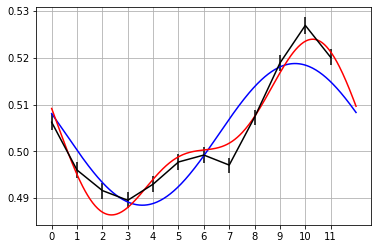

[10. -0.]
[-121.291484440427, -130.090601919970, -106.508070689405]
2nd order cosinor
acrophase =  10.0
maxmin/2 =  0.018921153860857
--------------
T4_FREE both


[10.60633301  0.49152471]
[-126.190447224145, -132.157159633920, -110.131369094633]
2nd order cosinor
acrophase =  10.606333007733218
maxmin/2 =  0.014926074537668305
--------------
ESTRADIOL_E_2 female


[2.45112294 0.66994465]
[-134.667628725963, -136.812448602238, -134.524470421602]
2nd order cosinor
acrophase =  2.451122939661145
maxmin/2 =  0.007318573664428249
--------------
ESTRADIOL_E_2 male


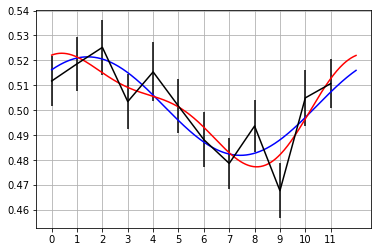

[1.64600013 1.51133383]
[-108.234388549455, -99.6963080946184, -98.8969271845947]
1st order cosinor
acrophase =  1.6460001327699076
maxmin/2 =  0.0328626775151685
--------------
ESTRADIOL_E_2 both


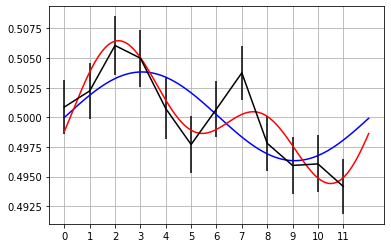

[2.53159646 1.57699275]
[-137.249322035386, -139.687623954444, -134.821452074917]
2nd order cosinor
acrophase =  2.531596458460327
maxmin/2 =  0.007169721427299517
--------------
TESTOSTERONE_TOTAL female


[3.23900229 1.01447528]
[-123.727189673206, -118.366595436257, -105.320784622638]
1st order cosinor
acrophase =  3.2390022927061177
maxmin/2 =  0.018190926209730427
--------------
TESTOSTERONE_TOTAL male


[1.14189149 0.61903195]
[-129.241360913624, -133.006961471767, -133.680204282502]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TESTOSTERONE_TOTAL both


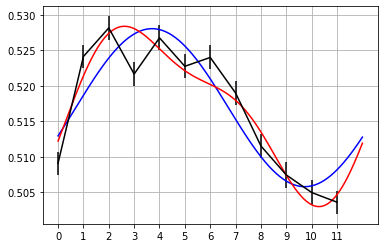

[2.55550952 1.03402645]
[-129.815927684909, -128.524590037185, -114.150413250839]
1st order cosinor
acrophase =  2.5555095221820427
maxmin/2 =  0.012765000892275733
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 female


[3.78710825 0.91138401]
[-90.3291447741151, -86.3108716237034, -84.0073061132002]
1st order cosinor
acrophase =  3.7871082501139384
maxmin/2 =  0.055394620793682056
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 male


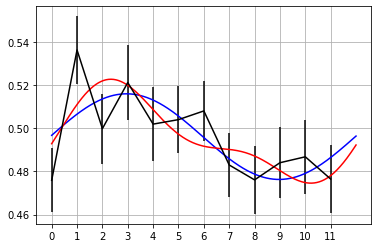

[1.64570393 1.35184574]
[-98.7854577195509, -90.0697243806414, -95.8247177956812]
1st order cosinor
acrophase =  1.6457039307269627
maxmin/2 =  0.040501105887242164
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 both


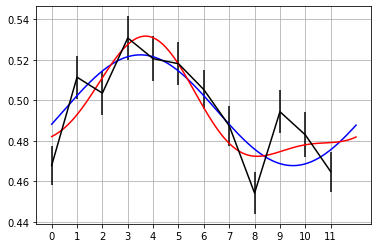

[3.40274468 0.95442569]
[-98.0696018007125, -91.7526755302214, -90.3955179498578]
1st order cosinor
acrophase =  3.4027446834720556
maxmin/2 =  0.041546160733984296



--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE female


[5.69006231 3.57460638]
[-95.4462431136863, -93.1835397954789, -98.2983554527111]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE male


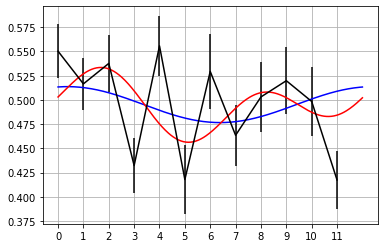

[2.52032281 2.97318303]
[-67.4886727670387, -59.8647265227628, -72.7907899806157]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE both


[3.06431696 3.31513247]
[-87.9719253117574, -79.6086350913851, -93.7325745376880]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TSH_THYROID_STIMULATING_HORMONE female


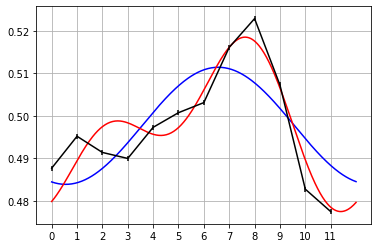

[8.00000000e+00 4.02472757e-08]
[-109.826680667543, -113.465917799121, -104.708859718582]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.022712300305531473
--------------
TSH_THYROID_STIMULATING_HORMONE male


[7.55934334 0.49938652]
[-117.334968910948, -117.479800925368, -107.597479546410]
2nd order cosinor
acrophase =  7.559343344792748
maxmin/2 =  0.01810268396199933
--------------
TSH_THYROID_STIMULATING_HORMONE both


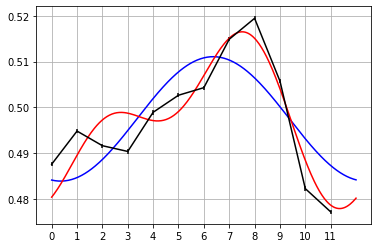

[8.00000000e+00 4.02472757e-08]
[-112.281144631635, -114.976486969589, -105.916924859356]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.02111140884149937
--------------
LH_LUTEINIZING_HORMONE female


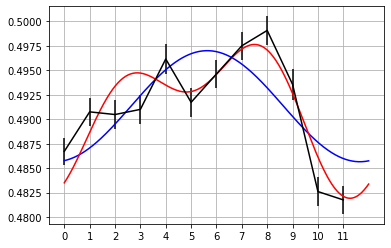

[7.70246559 0.87521051]
[-130.910202662604, -132.350097224496, -126.121390281873]
2nd order cosinor
acrophase =  7.702465591207099
maxmin/2 =  0.009044392457694993
--------------
LH_LUTEINIZING_HORMONE male


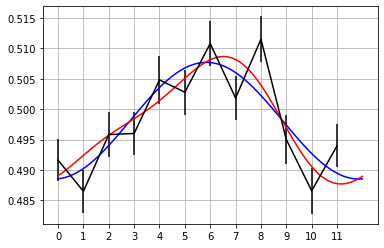

[7.06046301 1.1811238 ]
[-125.007705349280, -116.754703008538, -115.858074784582]
1st order cosinor
acrophase =  7.060463006373971
maxmin/2 =  0.014606710407256866
--------------
LH_LUTEINIZING_HORMONE both


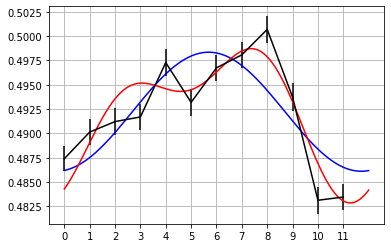

[7.86073826 0.63717799]
[-132.585943391717, -132.806393361231, -125.537486205794]
2nd order cosinor
acrophase =  7.86073825604369
maxmin/2 =  0.00914045529346128
--------------
FSH_FOLLICLE_STIMULATING_HORMONE female


[7.86081818 1.40562699]
[-144.822507268033, -139.861308154238, -147.802453677518]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
FSH_FOLLICLE_STIMULATING_HORMONE male


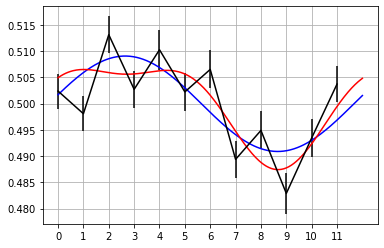

[2.60222972 1.18198439]
[-120.061776896776, -113.524334932389, -114.939658156593]
1st order cosinor
acrophase =  2.6022297171056876
maxmin/2 =  0.015730562142152012
--------------
FSH_FOLLICLE_STIMULATING_HORMONE both


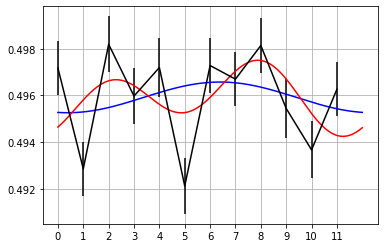

[4.47559128 4.00095514]
[-144.461223568541, -137.520642064820, -149.915197112641]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH female


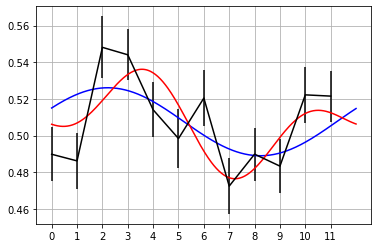

[2.39703242 1.02843938]
[-88.6745218957918, -83.1677473646440, -90.1063754145409]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH male


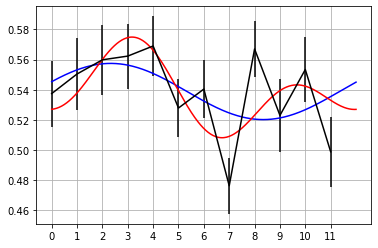

[3.53453522 3.16395548]
[-83.5703526295385, -77.9489139336507, -86.4256120669108]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH both


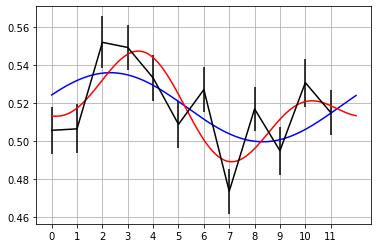

[2.44247071 1.07360642]
[-91.7036138913861, -87.0880908748354, -92.3028001420262]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
PROLACTIN female


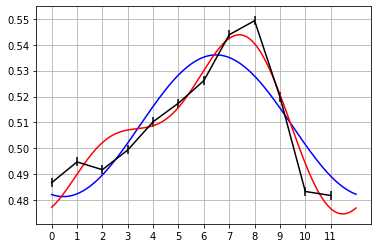

[7.99617824 0.06241705]
[-103.641466424403, -106.747732872292, -91.5496441343453]
2nd order cosinor
acrophase =  7.996178238388326
maxmin/2 =  0.03405343967497894
--------------
PROLACTIN male


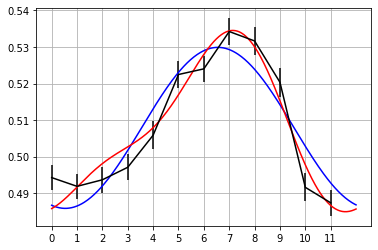

[7.29074389 0.50005705]
[-116.516237509348, -116.027933396784, -98.2340006515781]
1st order cosinor
acrophase =  7.290743890738163
maxmin/2 =  0.02447181315936342
--------------
PROLACTIN both


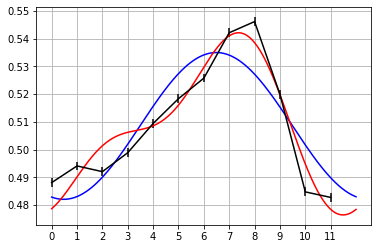

[7.97700887 0.15154492]
[-105.845567268590, -108.791647926057, -92.7325027881292]
2nd order cosinor
acrophase =  7.977008869828949
maxmin/2 =  0.03185247361779029



In [5]:
effector_list  = gen_hormone_list(effector_hormone_dic)
pituitary_list = gen_hormone_list(pituitary_hormone_dic)

--------------
ALDOSTERONE_BLOOD female


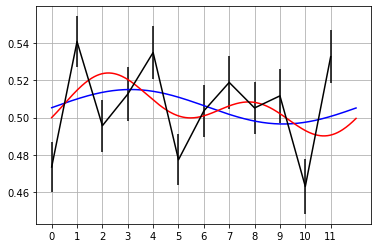

[1.354365   2.35588451]
[-84.7227065938551, -76.8861470555841, -89.7049222321921]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD male


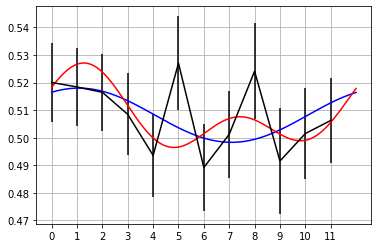

[4.67273267 3.68218282]
[-100.630522454466, -92.6319072459862, -105.184499483730]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD both


[0.77543371 1.84319509]
[-100.797921419853, -93.6185501074420, -105.158512222068]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ANDROSTENEDIONE female


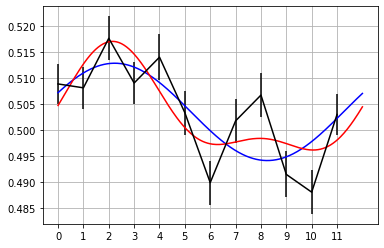

[2.477209   1.10043228]
[-116.543293188430, -110.431113372443, -113.055778580088]
1st order cosinor
acrophase =  2.4772090042699833
maxmin/2 =  0.016359161414191546
--------------
ANDROSTENEDIONE male


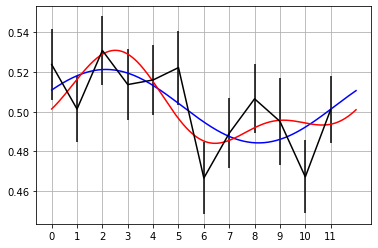

[2.47228306 2.19061107]
[-94.5082294482284, -85.8318152275757, -93.9974665987151]
1st order cosinor
acrophase =  2.4722830616617597
maxmin/2 =  0.04470903609866932
--------------
ANDROSTENEDIONE both


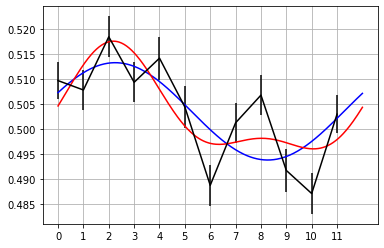

[2.31928423 0.88608195]
[-115.343660373799, -108.976727298936, -111.902123930605]
1st order cosinor
acrophase =  2.3192842250596533
maxmin/2 =  0.017081392042142953
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME female


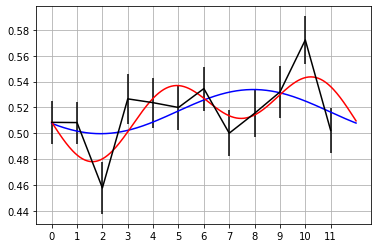

[9.86683549 1.1901667 ]
[-84.9364424552445, -81.6004563377601, -87.9338751948652]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME male


[3.11293168 2.50824873]
[-98.9514915428294, -89.7539286931298, -99.3733656975052]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME both


[9.34830242 2.81066721]
[-96.7004280219759, -90.3362274831260, -101.544891967604]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
DHEA_SULPHATE female


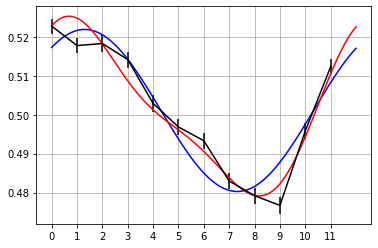

[0.13003194 0.46639937]
[-122.164401174368, -123.592636988489, -100.130261959968]
2nd order cosinor
acrophase =  0.13003193642634414
maxmin/2 =  0.023314121439606365
--------------
DHEA_SULPHATE male


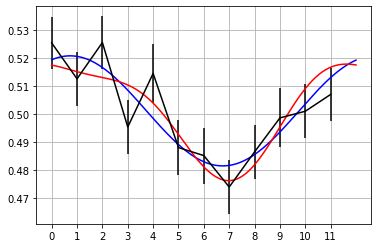

[1.23407134 1.32387501]
[-110.899755058651, -101.718828365825, -99.8066286226847]
1st order cosinor
acrophase =  1.2340713408665351
maxmin/2 =  0.030820681143740227
--------------
DHEA_SULPHATE both


[0.1419212 0.5119184]
[-123.391406317894, -124.957024977570, -100.351432032195]
2nd order cosinor
acrophase =  0.14192119649303914
maxmin/2 =  0.022913194050125194
--------------
PARATHYROID_HORMONE_PTH female


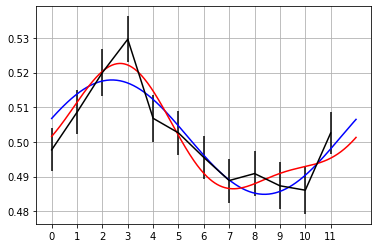

[2.8464712  0.37939466]
[-118.948493872536, -114.000685307245, -104.575664350262]
1st order cosinor
acrophase =  2.846471196902427
maxmin/2 =  0.024522718226310032
--------------
PARATHYROID_HORMONE_PTH male


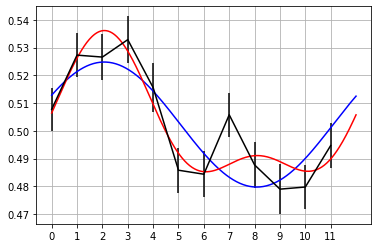

[2.39193513 0.92025128]
[-104.455217747202, -103.950665576976, -95.2616227476719]
1st order cosinor
acrophase =  2.3919351315493125
maxmin/2 =  0.03176676373300461
--------------
PARATHYROID_HORMONE_PTH both


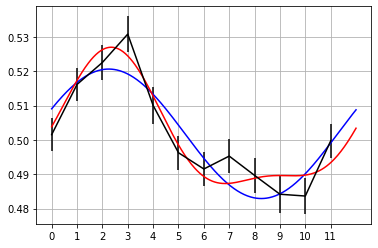

[2.90619616 0.30737231]
[-117.220750246332, -115.797771968222, -101.606272311117]
1st order cosinor
acrophase =  2.906196156809865
maxmin/2 =  0.02565249152336714
--------------
17_HYDROXY_PROGESTERONE female


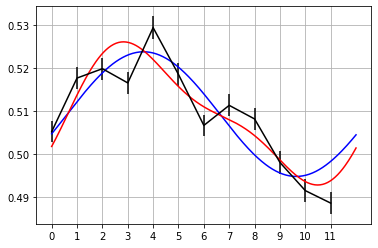

[3.98618754 0.19072581]
[-119.199654510507, -114.723437344584, -106.966824303438]
1st order cosinor
acrophase =  3.9861875385600802
maxmin/2 =  0.02063135839347218
--------------
17_HYDROXY_PROGESTERONE male


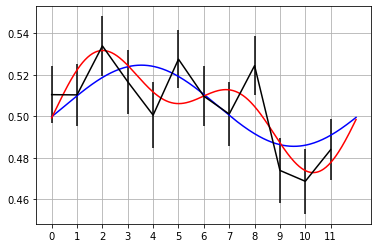

[3.16820258 2.56235999]
[-95.8273717975807, -92.8018717722153, -94.1282017159355]
1st order cosinor
acrophase =  3.1682025823538513
maxmin/2 =  0.04122224767980046
--------------
17_HYDROXY_PROGESTERONE both


[3.98386681 0.21812018]
[-119.224968528336, -115.126186520924, -106.797897235795]
1st order cosinor
acrophase =  3.983866814781974
maxmin/2 =  0.020301089655734846
--------------
PROGESTERONE female


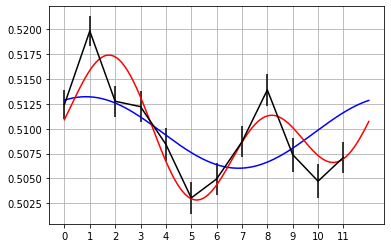

[1.00191037 0.04417392]
[-128.217098401410, -132.306976335426, -129.360715570444]
2nd order cosinor
acrophase =  1.0019103705623913
maxmin/2 =  0.008614643708812967
--------------
PROGESTERONE male


[1.92534463 1.72573917]
[-115.896379347445, -105.397118796287, -108.113088097225]
1st order cosinor
acrophase =  1.9253446274974935
maxmin/2 =  0.027303276433961535
--------------
PROGESTERONE both


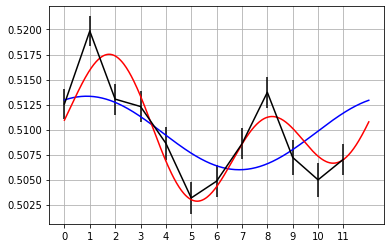

[1.00141043 0.25294103]
[-128.601007623126, -132.661255276540, -129.376082448669]
2nd order cosinor
acrophase =  1.0014104297454574
maxmin/2 =  0.008606906859953379



--------------
CALCIUM_BLOOD female


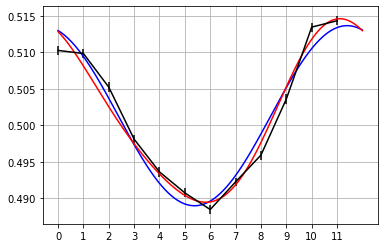

[10.86398478  0.34585302]
[-146.279372290339, -141.711958298830, -113.335428640415]
1st order cosinor
acrophase =  10.86398478439629
maxmin/2 =  0.012957149489471844
--------------
CALCIUM_BLOOD male


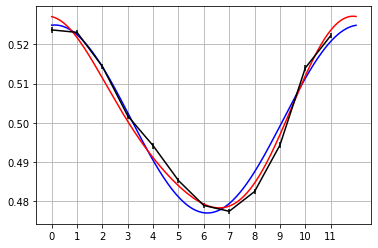

[0.20131179 0.47555149]
[-134.503609631393, -133.159304816844, -97.6622909294424]
1st order cosinor
acrophase =  0.20131178759418222
maxmin/2 =  0.023169223706154
--------------
CALCIUM_BLOOD both


[11.01339392  0.11626053]
[-142.140649330555, -138.524488377698, -105.668571015354]
1st order cosinor
acrophase =  11.01339391827125
maxmin/2 =  0.01670107038594372
--------------
CREATININE_BLOOD female


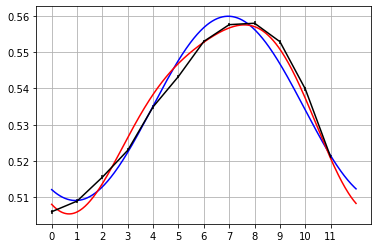

[7.71403247 0.45497581]
[-128.697350831498, -130.475015194715, -96.0149305981707]
2nd order cosinor
acrophase =  7.7140324712740505
maxmin/2 =  0.026080409836851937
--------------
CREATININE_BLOOD male


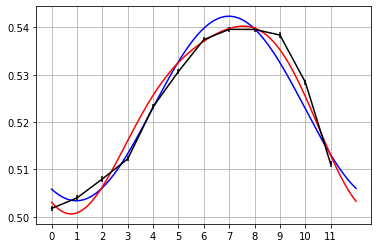

[7.51648829 0.55813608]
[-133.376443111380, -131.922301414133, -102.323718721541]
1st order cosinor
acrophase =  7.516488292962714
maxmin/2 =  0.01902715634355858
--------------
CREATININE_BLOOD both


[7.61245382 0.49015908]
[-131.008045760232, -131.628500583117, -98.5521147200096]
2nd order cosinor
acrophase =  7.612453820407135
maxmin/2 =  0.022946512824876877
--------------
Cl female


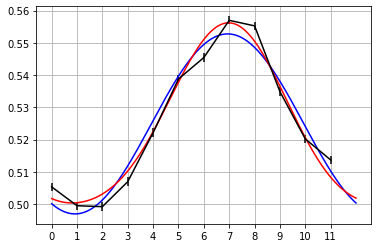

[7.18558939 0.39192512]
[-126.889058487891, -123.066413857379, -93.8123378526446]
1st order cosinor
acrophase =  7.185589391842878
maxmin/2 =  0.029224487658551245
--------------
Cl male


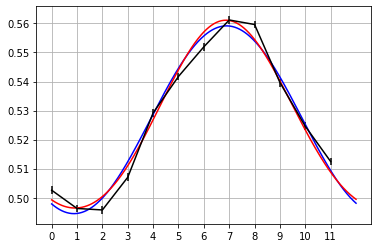

[7.1975537  0.40131088]
[-130.067985914098, -122.858334924404, -90.4908104542021]
1st order cosinor
acrophase =  7.197553700261206
maxmin/2 =  0.0330487055435687
--------------
Cl both


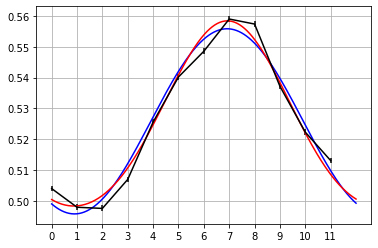

[7.09279458 0.29295235]
[-129.102423840580, -123.561343735949, -92.1843721663045]
1st order cosinor
acrophase =  7.0927945810958795
maxmin/2 =  0.030941887968825646
--------------
GLUCOSE_BLOOD female


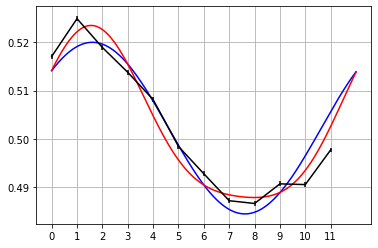

[ 1. -0.]
[-128.838840770514, -126.473859956338, -104.075431249160]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.01920870282723842
--------------
GLUCOSE_BLOOD male


[ 1. -0.]
[-127.965761207814, -125.680085025171, -101.012794936940]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.02148765249365845
--------------
GLUCOSE_BLOOD both


[ 1. -0.]
[-128.435574928432, -126.137175965684, -102.672471408995]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.020208753100547008
--------------
HEMOGLOBIN_A1C_CALCULATED female


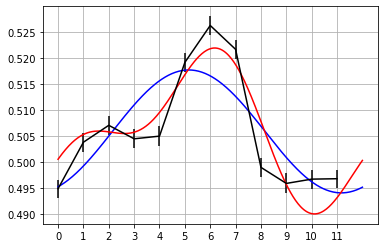

[6.02876132 0.16897539]
[-116.828426425907, -116.998010248490, -109.690469112166]
2nd order cosinor
acrophase =  6.028761322681227
maxmin/2 =  0.016226920937847927
--------------
HEMOGLOBIN_A1C_CALCULATED male


[6.3503887  0.74496259]
[-114.144795859244, -122.247066892106, -111.710853602617]
2nd order cosinor
acrophase =  6.350388703368833
maxmin/2 =  0.014594044951200825
--------------
HEMOGLOBIN_A1C_CALCULATED both


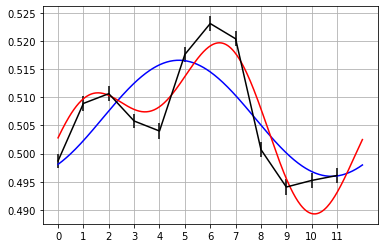

[6.05580378 0.23193501]
[-116.344022728556, -120.170963769798, -111.476653533432]
2nd order cosinor
acrophase =  6.055803782388352
maxmin/2 =  0.014761549820881669
--------------
HGB female


[0.00191037 0.04417392]
[-141.483468890642, -138.810348720840, -108.823587497413]
1st order cosinor
acrophase =  0.0019103705623914904
maxmin/2 =  0.014477675075924424
--------------
HGB male


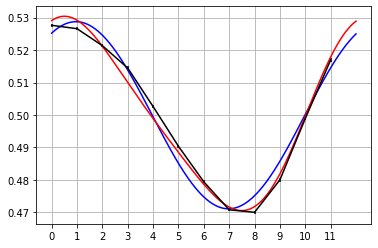

[0.07523216 0.26640941]
[-129.619654489664, -132.458910563574, -93.1526378874431]
2nd order cosinor
acrophase =  0.07523216129064203
maxmin/2 =  0.028843298060998463
--------------
HGB both


[ 0. -0.]
[-136.571356798701, -137.290613772371, -100.785327221388]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.02060913770769266
--------------
MAGNESIUM_BLOOD female


[6.06953579 1.18292536]
[-128.822445716113, -120.559664042850, -120.679847055007]
1st order cosinor
acrophase =  6.0695357854916345
maxmin/2 =  0.012097959408466672
--------------
MAGNESIUM_BLOOD male


[10.35246743  3.68449645]
[-127.598572012413, -123.144363384873, -131.493246005165]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
MAGNESIUM_BLOOD both


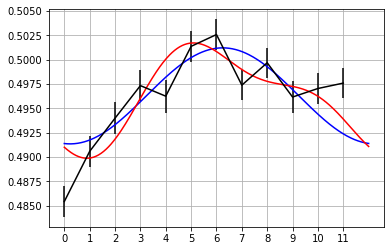

[5.82197768 0.78691917]
[-135.688431165640, -129.602946116653, -129.981910385538]
1st order cosinor
acrophase =  5.821977679816388
maxmin/2 =  0.008735040464586834
--------------
POTASSIUM female


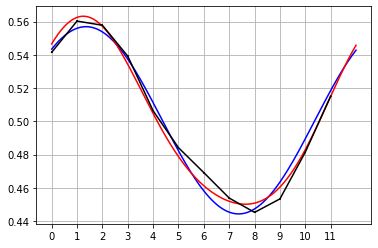

[ 1. -0.]
[-116.037095580992, -115.255010194662, -77.1451056786820]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.05755169205930872
--------------
POTASSIUM male


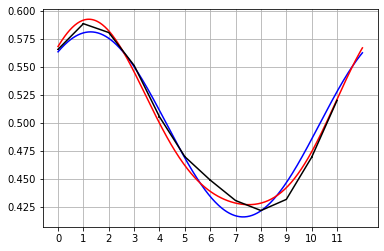

[ 1. -0.]
[-105.406947883927, -107.722263529507, -67.9254557044099]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.08341087938001197
--------------
POTASSIUM both


[ 1. -0.]
[-110.853904837480, -111.976942281345, -72.6339332216844]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.06908594345946582
--------------
SODIUM female


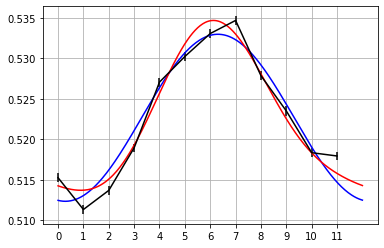

[6.98660608 0.11626053]
[-145.375867468753, -143.284516891503, -117.383612622155]
1st order cosinor
acrophase =  6.986606081728747
maxmin/2 =  0.011705323951311988
--------------
SODIUM male


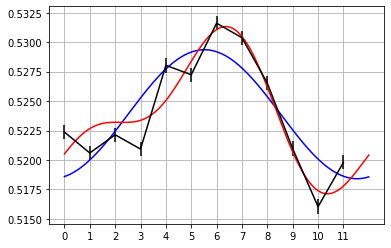

[6.07717999 0.26954141]
[-139.039756588795, -140.608445769322, -129.384839465354]
2nd order cosinor
acrophase =  6.077179994876503
maxmin/2 =  0.0078047771703126205
--------------
SODIUM both


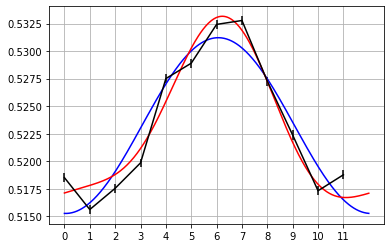

[6.73623756 0.44379952]
[-144.881717568492, -144.381776742232, -123.052144343204]
1st order cosinor
acrophase =  6.736237560045348
maxmin/2 =  0.0086573854599274
--------------
UREA_BLOOD female


[4.72413326 0.45006404]
[-147.059826630348, -138.570572264299, -116.836970715733]
1st order cosinor
acrophase =  4.724133263336623
maxmin/2 =  0.012104555658780741
--------------
UREA_BLOOD male


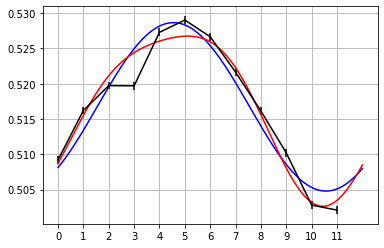

[4.98468863 0.12417781]
[-139.919328227189, -137.376814127887, -113.825621254871]
1st order cosinor
acrophase =  4.984688631451089
maxmin/2 =  0.013522692791700198
--------------
UREA_BLOOD both


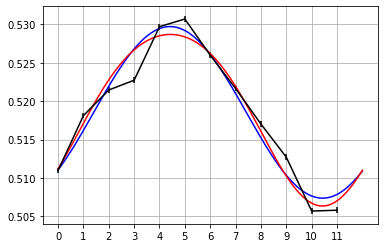

[4.98085074 0.13858847]
[-145.537258900504, -138.880797400096, -115.626481144076]
1st order cosinor
acrophase =  4.980850736538734
maxmin/2 =  0.012577557928416045



In [6]:
residual_list  = gen_hormone_list(residual_hormone_dic)
chem_list      = gen_hormone_list(chem_dic)

In [7]:
pickle.dump([pituitary_list,effector_list,residual_list,chem_list],open('seasonality_processed_data_SI_0302_20_50.pickle','wb'))

In [8]:
[pituitary_list,effector_list,residual_list,chem_list] = pickle.load(open('seasonality_processed_data_SI_0302_20_50.pickle','rb'))

In [9]:
'''
plot effector hormones seasonality
'''
eff_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(effector_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]
                
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        eff_r2df = eff_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))
        
        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        y_percentage   = (yloc-yloc.mean())*100;
        err_precentage = err*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        ## x0 = Dec 15, so add 6 days to get Dec 21st
        ## in month resulotion, 6 days are 0.2 month
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

In [10]:
'''
plot pituitary hormones seasonality
'''
pit_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(pituitary_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        # months are stored iin the dataframe in a january-december fmt, 
        # this part will make december as the 0th month
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        pit_r2df = pit_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
            
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100

        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

D:\Anaconda\envs\venv\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [11]:
'''
plot residual hormones seasonality
'''
residual_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(residual_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = residual_list[residual_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        residual_r2df = residual_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100
        err_precentage = err*100

        #plot
        ax = plt.subplot(9,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[2],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(residual_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
         
plt.tight_layout()
plt.show()

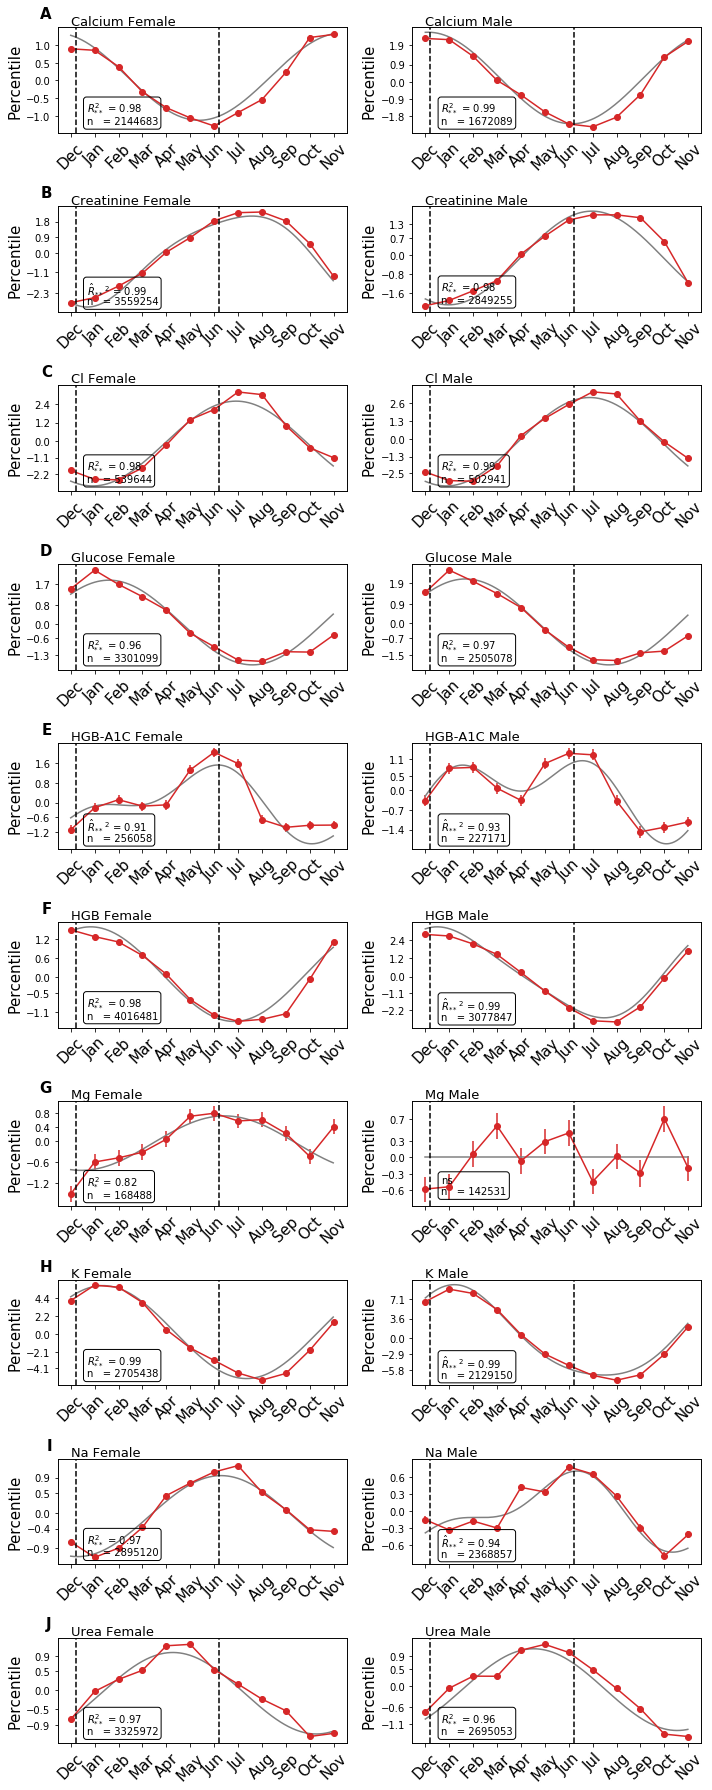

In [12]:
'''
plot chemistry seasonality
'''
chem_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(chem_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = chem_list[chem_dic[k]][sex]['Clalit']['xloc']
        yloc    = chem_list[chem_dic[k]][sex]['Clalit']['yloc']
        err     = chem_list[chem_dic[k]][sex]['Clalit']['err']
        ntot    = chem_list[chem_dic[k]][sex]['Clalit']['ntot']
        phase   = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][1]
        
        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        chem_r2df = chem_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100
        #plot
        ax = plt.subplot(10,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[3],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(chem_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
       
plt.tight_layout()
plt.show()

# FIG 1 complete

In [13]:
 def HPA_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('A'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('ACTH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Cortisol',[-1.12+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.725, 0.2, 0.2], anchor='SW', zorder=-1)
    
    newax.imshow(plt.imread('../figures/ppt/glands/adrenal.png'))
    
    newax.text(0.2, 1.08, 'Stress adaptation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    
    newax.text(0.2, 0.2, 'Adrenal Cortex', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    

    newax.text(0.16, 1.09, 'A', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')

    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def HPT_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('TSH'   ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T4',[-0.87+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('T3'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.528, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/thyroid.png'))
    
    newax.text(0.2, 1.08, 'Thermoregulation \n   & metabolism', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, 'Thyroid', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'B', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)
    
def HPG_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('G'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('LH'   ,[-0.9+xoff ,-0.15+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('FSH'  ,[-0.9+xoff ,-0.35+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Test',[-0.9+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('E2'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.357, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/gonads.png'))
    
    newax.text(0.2, 1.08, 'Reproduction', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, '  Gonads', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'C', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    

def HPL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.6     
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('L'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('GH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('IGF-1',[-1.05+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.133, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/liver.png'))
    
    newax.text(0.2, 1.08, 'Growth', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.56, '    Liver', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'D', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def PRL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.45 
    ax.annotate('H'    ,[-1   +xoff,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1   +xoff,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('PRL'  ,[-1.05+xoff,-0.45+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, 0.3 +Yoff],
                xy    =[-0.97  +xoff,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, -0.1 +Yoff],
                xy    =[-0.97  +xoff,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))

    newax = fig.add_axes([-0.2, 0.035, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/breasts.png'))
    
    newax.text(0.2, 1.08, 'Lactation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.45, '    Breasts', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'E', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    
        
def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=15,empty=False,fontsize=15):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,mec='k')
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]),fontsize=fontsize)
    

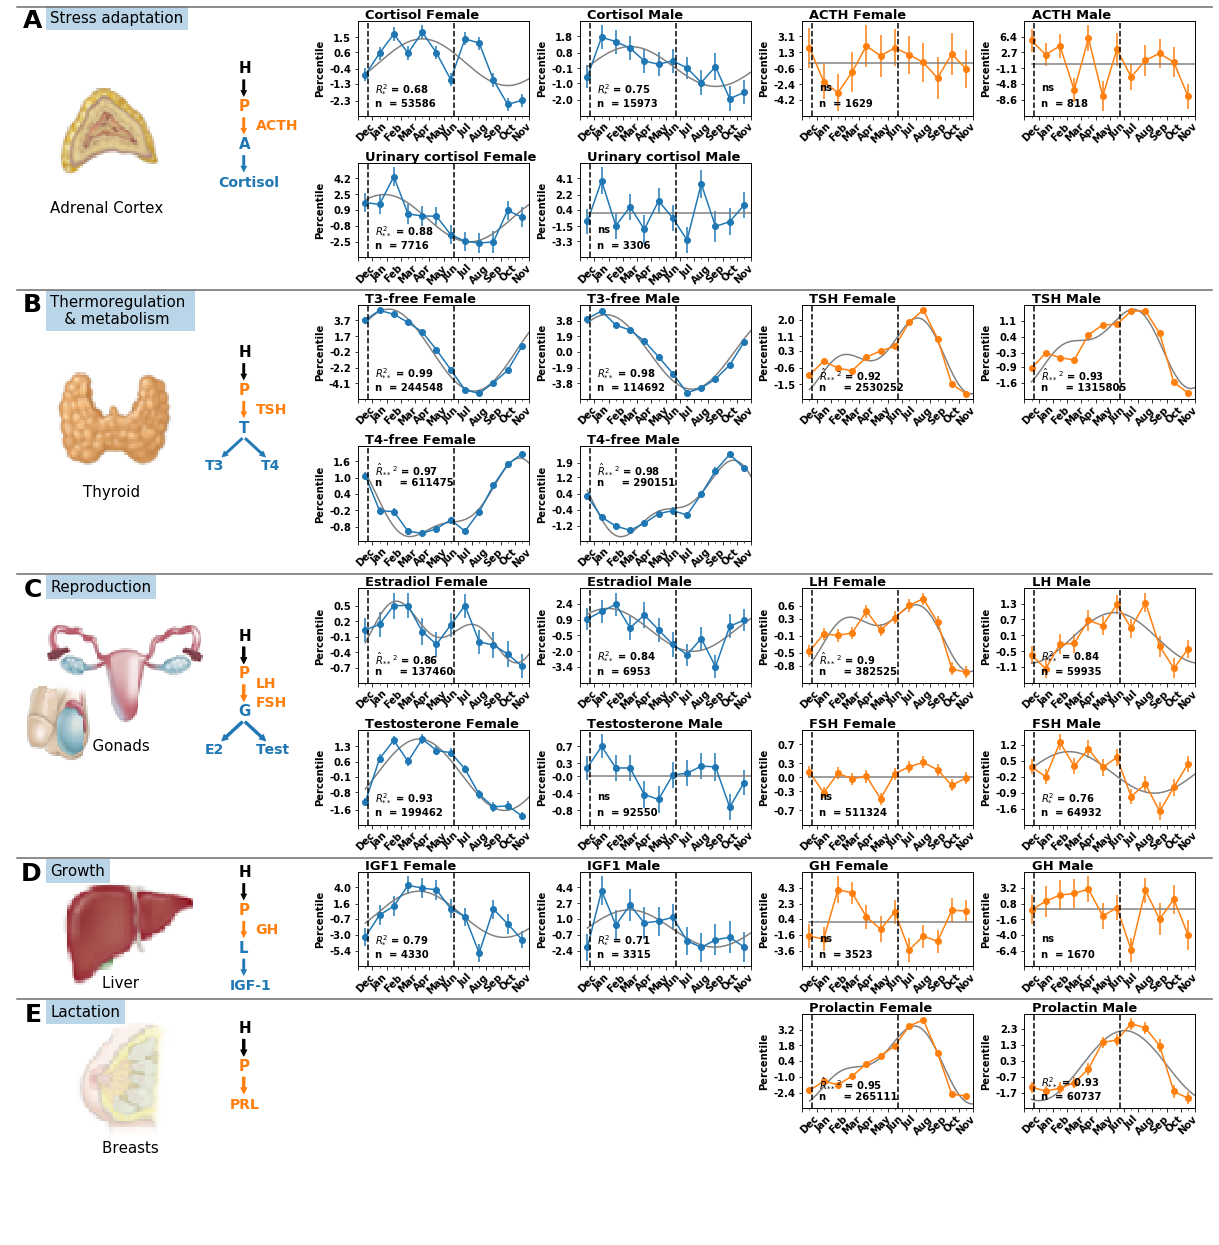

In [14]:
'''
FIG 1 -  Code to plot cosinor fit subplots
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(15,20))
gs  = fig.add_gridspec(8, 4)
ax  = fig.add_subplot(gs[0,0]); HPA_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[2,0]); HPT_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[4,0]); HPG_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[6,0]); HPL_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[7,0]); PRL_graph_on_axe(ax,fig);  ax.axis('off')
month_names0  = np.roll(month_names,1)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
           
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel(effector_unit_dict[effector_hormone_dic[k]],fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 
            
        if k == 'T4_FREE':
            ax.text(0.1, 0.85, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.675, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        else:
            ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
             
PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)

        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100;  fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel(pituitary_unit_dict[pituitary_hormone_dic[k]],fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        if ax.get_ylim()[1]<0.7:
            ax.set_ylim([-1,1])
        
        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        
        axn = ax.twinx(); axn.set_yticks([]); 
        axn.axvline(x=0.2,ls='--',c='k'); axn.axvline(x=6.2,ls='--',c='k')
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 

        ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

plt.subplots_adjust(hspace=0.5,wspace =0.3)
plt.savefig('../figures/Seasonality03022020/FigureSI_fig1_20_50_0302.png',bbox_inches='tight',dpi=600)
plt.show()

In [18]:
'''
FIG 2AB -  Code to phase plot, and summery
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(22,8))
gs  = fig.add_gridspec(4, 6)

uy = 0.06/100
ux = 12/100
pit_loc = [(2*ux,-uy),(-6*ux,3*uy),(-4*ux,-6*uy),(-4*ux,-6*uy),(-6*ux,4*uy),(-6*ux,4*uy)]
eff_loc = [(-9*ux,3*uy),(ux*-4,3*uy),(ux*2,1*uy),(-11*ux,3*uy),(-10*ux,-5*uy),(-5*ux,2*uy),(ux,-4*uy),(2*ux,-4*uy),(-5*ux,-6*uy),(-5*ux,4*uy)]

temp    = eff_r2df.loc[eff_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

temp    = pit_r2df.loc[pit_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

eff_rel_maxmin     = []
eff_acrophase      = []
eff_rel_maxmin_std = []
eff_acrophase_std  = []
eff_names          = []

for hormone in eff_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

pit_rel_maxmin     = []
pit_acrophase      = []
pit_rel_maxmin_std = []
pit_acrophase_std  = []
pit_names          = []

for hormone in pit_big:
    name = hormone[0]
    if name == 'GROWTH_HORMONE_GH':
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    sex_one_letter = sex[0]
    pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)


'''
FIG 2A -  Code to plot phase/amp 
'''
axbig = fig.add_subplot(gs[:,:3])
ax    = fig.add_subplot(gs[:,3:])

plot_phase_amp(axbig,
               np.array(eff_rel_maxmin),
               np.array(eff_acrophase), 
               np.array(eff_rel_maxmin_std),
               np.array(eff_acrophase_std),
               eff_names,
               color=def_color[0],
               loc_list=eff_loc)

plot_phase_amp(axbig,
               np.array(pit_rel_maxmin),
               np.array(pit_acrophase), 
               np.array(pit_rel_maxmin_std),
               np.array(pit_acrophase_std),
               pit_names,
               color=def_color[1],
               loc_list=pit_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
# axbig.tick_params(which='minor', length=8,labelsize =20)
# axbig.tick_params(which='major', length=0,labelsize =20)
axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

axbig.set_xticks(np.arange(12))
axbig.set_xticklabels(month_names0, rotation=45)
axbig.tick_params(axis='x',labelsize =20)
axbig.tick_params(axis='y',labelsize =20)

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 4.5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,13,1)-0.5)
axbig.set_xticklabels([])
axbig.set_xticks(np.arange(0,12,1),minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)
axbig.set_xlim([-0.5,11.5])
###########################################
###########################################
###########################################

'''
FIG 2B -  Code to calculate average effector hormones seasonality
'''
stack_eff_cos = []
stack_pit_cos = [] 
                                              
for j,hormone in enumerate(eff_big):
    name = hormone[0]
    if name in ['T3_FREE','T4_FREE']:
        continue
    sex  = hormone[1]
    acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_eff_cos.append([acrophase,relmaxmin])            
    
for j,hormone in enumerate(pit_big):
    name = hormone[0]
    if name in ['TSH_THYROID_STIMULATING_HORMONE','GROWTH_HORMONE_GH','PROLACTIN']:
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_pit_cos.append([acrophase,relmaxmin])

p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3) 

p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
# relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
pit_cos   = 1+0.8*relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)

mn = np.roll(month_names,1)
mn = np.insert(mn, 12, mn[0])
ax.set_yticks([])

ax.set_xticks(0.5+np.arange(12))
ax.set_xticklabels(mn, rotation=45)
ax.set_xlim([0,12])
ax.set_ylim([1-relmaxmin*1.5,1+relmaxmin*1.5])

ax.tick_params(axis='x',labelsize =20)

ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.85, 0,head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.annotate('Delay',[0.9,1.027],fontsize=20)

ax.annotate('Pituitary \nHormone',fontsize=20,
            xy=(9, pit_cos[9*30]), xycoords='data',
            xytext=(9.1, 1.02), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.annotate('Effector \nHormone',fontsize=20,
            xy=(3, eff_cos[3*30]), xycoords='data',
            xytext=(1, 1.003), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.scatter(eff_cos.argmax()*12/365, eff_cos.max(),s=180,c=def_color[0])
ax.scatter(eff_cos.argmin()*12/365, eff_cos.min(),s=180,c=def_color[0])
ax.scatter(pit_cos.argmax()*12/365, pit_cos.max(),s=180,c=def_color[1])

ax.plot([pit_cos.argmax()*12/365,pit_cos.argmax()*12/365],[pit_cos.max(),eff_cos[pit_cos.argmax()]],c=def_color[1],lw='3')
ax.plot([eff_cos.argmin()*12/365,eff_cos.argmin()*12/365],[eff_cos.min(),pit_cos[eff_cos.argmin()]],c=def_color[0],lw='3')

ax.annotate('Approximate \n anti-phase',[6.7,0.99],fontsize=20)

mid    = np.mean([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])
ar_len = np.diff([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])[0]/3

ax.arrow(mid, 1, ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.arrow(mid, 1, -ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)

ax.text(-0.02, 1.1, 'B', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax.axvline(x=0.7,ls='--',c='k')
ax.axvline(x=6.7,ls='--',c='k')

ax.set_xticks(np.arange(0,13,1))
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)

plt.subplots_adjust(hspace=0.4,wspace =0.8)
plt.savefig('../figures/Seasonality03022020/FigureSI_fig2_20_50_0302.png',bbox_inches='tight',dpi=600)
plt.show()

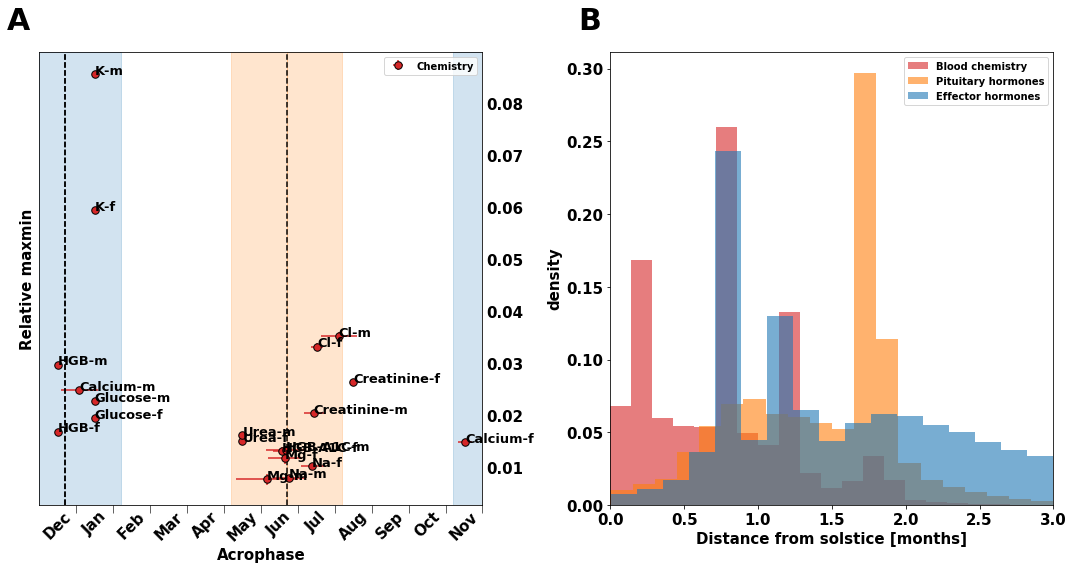

effector & chemistry,  Ks_2sampResult(statistic=0.44861666666666666, pvalue=0.0)
pituitary & chemistry,  Ks_2sampResult(statistic=0.2062222222222222, pvalue=6.025644307221098e-134)
Chem distance from solstice (mean, std) [0.7673928026462108, 0.48617615141540765]
Hormone distance from solstice (mean, std) [1.4503050847075423, 0.6424254812297705]


In [25]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
uy = 0.085/100
ux = 12/100
chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
            (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(0,0),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
chem_loc = [(0,0) for i in chem_names] 

chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (15,8))   
axbig = plt.subplot(1,2,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color=def_color[3],
           loc_list=chem_loc,fontsize=13)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =15)
axbig.tick_params(which='major', length=0,labelsize =15)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 15,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 15,'fontweight':'bold'})

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,12,1))
axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=15,fontweight='bold',minor =False)
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
# plt.show()

dec21 = 0.2
jun21 = 6.2
dec21B = 12.2
def distance_from_solstice(acrophases_list):
    return [np.min(np.abs([dD1,dD2,dJ])) for dD1,dD2,dJ in zip(np.array(acrophases_list) - dec21,np.array(acrophases_list) - dec21B,np.array(acrophases_list) - jun21)]

Dche = []; Deff = []; Dpit = []

for bootstrap in range(1000):
    chem_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(chem_acrophase,np.abs(chem_acrophase_std))])
    Dche += distance_from_solstice(chem_acrophase_boot)

    eff_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(eff_acrophase,np.abs(eff_acrophase_std))])
    Deff += distance_from_solstice(eff_acrophase_boot)
    
    pit_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(pit_acrophase,np.abs(pit_acrophase_std))])
    Dpit += distance_from_solstice(pit_acrophase_boot)
   
eff_weights = np.ones_like(Deff)/float(len(Deff))
pit_weights = np.ones_like(Dpit)/float(len(Dpit))
che_weights = np.ones_like(Dche)/float(len(Dche))

ax1 = plt.subplot(1,2,2);
ax1.text(-0.02, 1.1, 'B', transform=ax1.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax1.hist(Dche,color=def_color[3],alpha=0.6,bins=20,weights=che_weights);
ax1.hist(Dpit,color=def_color[1],alpha=0.6,bins=20,weights=pit_weights);
ax1.hist(Deff,color=def_color[0],alpha=0.6,bins=20,weights=eff_weights); 
ax1.set_xlim([0,3])
ax1.legend(['Blood chemistry','Pituitary hormones','Effector hormones'])
ax1.set_xlabel('Distance from solstice [months]',fontsize=15,fontweight='bold')
ax1.set_ylabel('density',fontsize=15,fontweight='bold')
ax1.tick_params(axis='x',labelsize =15)
ax1.tick_params(axis='y',labelsize =15)
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.savefig('../figures/Seasonality03022020/SI_Chem_phase_amp_0302.png',bbox_inches='tight',dpi=600)
plt.show()

print('effector & chemistry, ', stats.ks_2samp(Deff, Dche))
print('pituitary & chemistry, ',stats.ks_2samp(Dpit, Deff))
print('Chem distance from solstice (mean, std)',[np.mean(Dche),np.std(Dche)])
print('Hormone distance from solstice (mean, std)',[np.mean(Dpit +Deff),np.std(Dpit +Deff)])

In [21]:
table = []
for key in pituitary_list.keys():
    for sex in ['female','male']:
        table.append([key] + [sex] + [pituitary_list[key][sex]['Clalit']['ntot']] + [pituitary_list[key][sex]['Clalit']['yloc'].mean()] + [pituitary_list[key][sex]['Clalit']['err'].mean()] + pituitary_list[key][sex]['Cosinor']['pars'][0] + pituitary_list[key][sex]['Cosinor2']['pars'][0] + pituitary_list[key][sex]['Cosinor']['pars'][1] + pituitary_list[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df    = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])

table = []
for key in effector_list.keys():
    for sex in ['female','male']:
        table.append([key] + [sex] + [effector_list[key][sex]['Clalit']['ntot']] + [effector_list[key][sex]['Clalit']['yloc'].mean()] + [effector_list[key][sex]['Clalit']['err'].mean()] + effector_list[key][sex]['Cosinor']['pars'][0] + effector_list[key][sex]['Cosinor2']['pars'][0] + effector_list[key][sex]['Cosinor']['pars'][1] + effector_list[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df2 = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])
df = pd.concat([df2,df])
df = df.drop(columns = ['acrophase2','maxmin2'])
print('Table S1')
display(df[['hormone','sex','n','M','Merr','phase','phase_std','amp','amp_std','phase2','phase2_std','amp2','amp2_std','maxmin','maxmin_std','acrophase','acrophase_std']])

Table S1


hormone     sex        n                    M  \
0           Cortisol  female    63175   0.5150220411982699   
1           Cortisol    male    21155   0.5116796376259668   
2   Urinary cortisol  female    12003   0.5138324409675353   
3   Urinary cortisol    male     5125   0.5080748844932872   
4            T3-free  female   345945   0.5070834315520638   
5            T3-free    male   162602   0.5051268886112837   
6            T4-free  female   899982    0.505828953146857   
7            T4-free    male   422709    0.504839463229084   
8          Estradiol  female   149177   0.5010414932237759   
9          Estradiol    male     7554   0.5038880124498989   
10      Testosterone  female   212613   0.5191111821232659   
11      Testosterone    male   132866   0.5137470698190655   
12              IGF1  female     5663  0.49813342139975875   
13              IGF1    male     4891   0.4977259385458717   
0               ACTH  female     2449   0.5046907930781128   
1               ACTH    male     1361   0.5080789197557996   
2                TSH  female  3920044   0.4981084526555817   
3                TSH    male  2095724   0.4962083470601752   
4                 LH  female   436231  0.48925459486533834   
5                 LH    male    72738  0.49794083119461335   
6                FSH  female   583366   0.4940669192732631   
7                FSH    male    78711   0.5001143323665085   
8                 GH  female     4821   0.5082302494285297   
9                 GH    male     2786   0.5397307090817339   
10         Prolactin  female   289112     0.50917017251982   
11         Prolactin    male    75031   0.5092413545937766   

                     Merr                phase             phase_std  \
0    0.003655577234869425   3.7403234979593014   0.22077049927401102   
1    0.006296470639523169   3.0087623199012556     0.468638745298814   
2    0.008267326643619231    1.576236492229329    0.2895195638395426   
3     0.01259645609657826                 -1.0                   0.0   
4   0.0015245368836001288   1.6526243937095701  0.022692144849682367   
5   0.0022235288861987327   1.3682803252784699   0.03694564437524368   
6   0.0009633870720264936  -0.7372839081274816  0.047622512866777135   
7   0.0013972114711589196   10.151932663736293   0.07022166650420807   
8   0.0023401167531657487   3.4714696529275564    0.4781793927067716   
9    0.010420630517734479    1.658592696682061   0.44230251837345236   
10   0.001968024718746526     3.73419152382825   0.09036450542547042   
11   0.002530262719731537  -0.8634064467275191     0.941904611682847   
12   0.012059687529978944     3.29606149360981    0.3414939410850155   
13   0.013022928145374292                 -1.0                   0.0   
0     0.01834106031188289    5.316289364090193     1.042918636088899   
1    0.025412685768355647                 -1.0                   0.0   
2   0.0004593829175048804    6.242976166552746   0.03562226455006447   
3   0.0006253106520747643    5.331263143702517   0.04748888919488531   
4   0.0013660095003182736     5.94795211634377   0.20307250066009913   
5   0.0033629576350561376    6.182761995337766    0.3098609307134905   
6   0.0011851068328058091    8.328820707258245   0.45777342027122414   
7      0.0032385065141326   2.7057358273434002   0.28009575675261333   
8    0.013016722063107717   2.8078539868225714    0.5273352027995396   
9    0.016750750368910668                 -1.0                   0.0   
10  0.0016767439749519697     6.43928609741057   0.05084438066161887   
11  0.0033108297451698234    6.589560486017916   0.12283308008540209   

                      amp                 amp_std              phase2  \
0    0.012988774593442628   0.0015926724425104931                -1.0   
1    0.011157938587287048    0.002650094447709264                -1.0   
2    0.021313214934701678   0.0032528749298844383                -1.0   
3                     0.0                     0.0                -1.0   
4    0.052409506963370475   